In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm,colors

In [2]:
from model import Model
from model import convertToOneHot, DataSet_meta

## Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2$

Group 2: $X$ ~ $N(-1,0.5)$, $Y =  X_3 - 2X_4$



In [5]:
def linear_simple_data_gen(n_sample = 500, seed = 42):
    rng = np.random.default_rng(seed)
    
    Xs1 = np.random.normal(loc=1,scale=0.5,size=(n_sample,4))
    Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]

    Xs2 = np.random.normal(loc=-1,scale=0.5,size=(n_sample,4))
    Ys2 = Xs2[:,2]-2*Xs2[:,3]
    
    X_data = np.concatenate((Xs1,Xs2),axis=0)
    Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)
    
    Y_data = Y_data-Y_data.min()
    Y_data=Y_data/Y_data.max()
    
    # The ground truth group label of each sample
    case_labels = np.concatenate((np.array([1]*n_sample),np.array([2]*n_sample)))
    
    Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)
    
    return X_data, Y_data

In [6]:
X_data, Y_data = linear_simple_data_gen()

In [11]:
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=42)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=42)
print("Train/Valid/Test sizes: {}/{}/{}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))

Train/Valid/Test sizes: 800/100/100


In [12]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [13]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [14]:
dataset = DataSet_meta(**{'_data':X_train, '_labels':y_train,'_meta':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,'_valid_meta':y_valid,
                '_test_data':X_test, '_test_labels':y_test,'_test_meta':y_test})

In [16]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,0,0] if label == 1 else [0,0,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,0,0] if label == 1 else [0,0,1,1] for label in test_label])

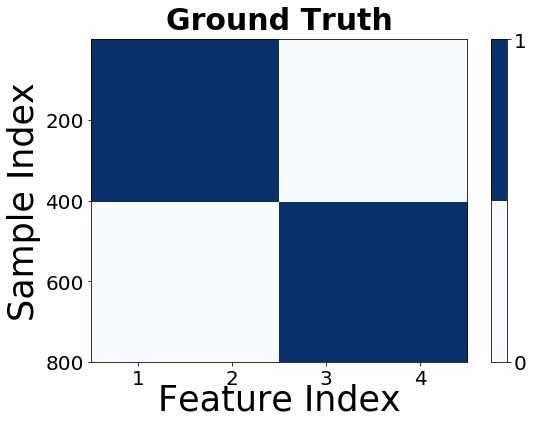

In [18]:
# visualize the ground truth features on the training set
cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

fig, axes = plt.subplots(1, 1,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes.imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes.set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes.set_ylabel("Sample Index",fontsize=ylabel_size)
axes.set_yticks([200,400,600,800])
axes.set_yticklabels([200,400,600,800],fontsize=ytick_size)
axes.set_xticks(list(range(4)))
axes.set_xticklabels(list(range(1,5)),fontsize=xtick_size)
axes.set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

## Run LLSPIN

In [57]:
# hyper-parameter specification
model_params = {     
    "input_node" : X_train.shape[1],       # input dimension for the prediction network
    "hidden_layers_node" : [100,100,10,1], # number of nodes for each hidden layer of the prediction net
    "output_node" : 1,                     # number of nodes for the output layer of the prediction net
    "feature_selection" : True,            # if using the gating net
    "gating_net_hidden_layers_node": [10], # number of nodes for each hidden layer of the gating net
    "display_step" : 500                   # number of epochs to output info
}
model_params['activation_pred']= 'none' # linear prediction
model_params['activation_gating'] = 'tanh'
model_params['batch_normalization'] = 'False'

model_params['lam'] = 5e-3


In [58]:
training_params = {
    'batch_size':X_train.shape[0],
    "lr":1e-1,
    "num_epoch":10000
} 

In [59]:
model = Model(**model_params)
train_acces, train_losses, val_acces, val_losses = model.train(dataset=dataset,**training_params)

num_samples : 800
Epoch: 500 train loss=0.016767448 valid loss= 0.013629722
Epoch: 1000 train loss=0.014332635 valid loss= 0.009840881
Epoch: 1500 train loss=0.010844952 valid loss= 0.007706206
Epoch: 2000 train loss=0.009384687 valid loss= 0.006143078
Epoch: 2500 train loss=0.008567016 valid loss= 0.004824609
Epoch: 3000 train loss=0.007319970 valid loss= 0.004121997
Epoch: 3500 train loss=0.007164987 valid loss= 0.003820428
Epoch: 4000 train loss=0.006108257 valid loss= 0.003579485
Epoch: 4500 train loss=0.006391070 valid loss= 0.003490650
Epoch: 5000 train loss=0.006267024 valid loss= 0.003442385
Epoch: 5500 train loss=0.005371733 valid loss= 0.003343649
Epoch: 6000 train loss=0.005749664 valid loss= 0.003389985
Epoch: 6500 train loss=0.005893863 valid loss= 0.003335554
Epoch: 7000 train loss=0.005956644 valid loss= 0.003324579
Epoch: 7500 train loss=0.005438792 valid loss= 0.003282265
Epoch: 8000 train loss=0.006128579 valid loss= 0.003285499
Epoch: 8500 train loss=0.006132436 vali

In [60]:
gate_mat_train = model.get_prob_alpha(X_train)

In [61]:
y_pred_llspin = model.test(X_test)[0]
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1))))

Test mse : 0.00027235682257454853
Test r2 : 0.9894594603393193


### Comparing the training gates to the ground truth

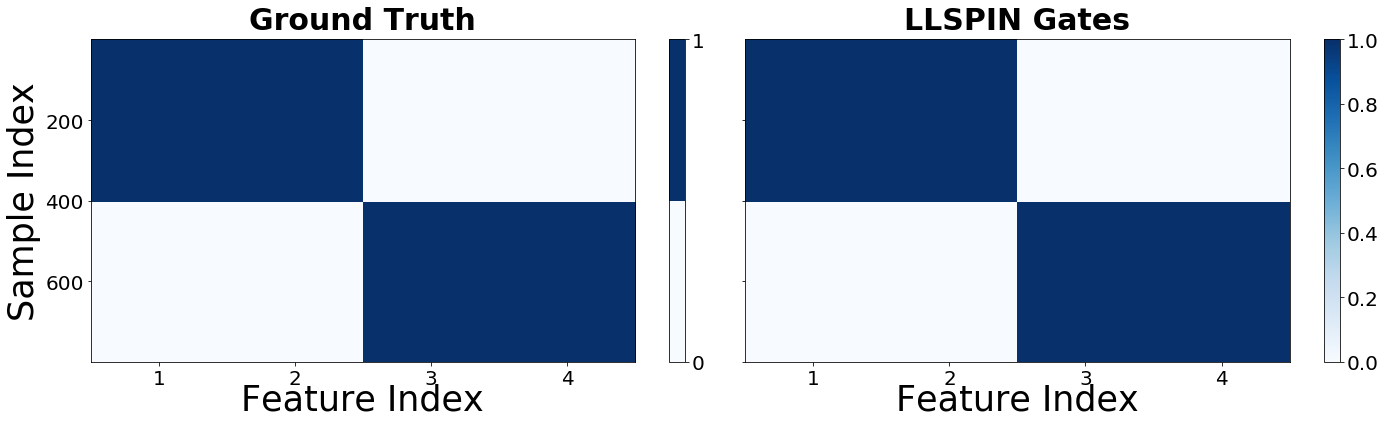

In [63]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(20, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([200,400,600,800])
axes[0].set_yticklabels([200,400,600,800],fontsize=ytick_size)
axes[0].set_xticks(list(range(4)))
axes[0].set_xticklabels(list(range(1,5)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([200,400,600,800])
axes[1].set_yticklabels([200,400,600,800],fontsize=ytick_size)
axes[1].set_xticks(list(range(4)))
axes[1].set_xticklabels(list(range(1,5)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()